# <center>Predicting delivery times for products sold on eBay</center>

## <center>Final project for STAT 5000</center>

## <center>Ujas Shah</center>

### <center>December 06, 2021</center>

GitHub:

## Abstract

Keywords: Machine Leaning, Linear Regression, CatBoost, Delivery Date Prediction.

<div style="page-break-after: always;"></div>

### Project Introduction

#### Acknowledgements
This project was made possible by eBay. As part of the eBay ML challenge (hosted on eval.ai), the company has shared a dataset related to purchases made on the website in the year 2018 and 2019, in order to find the most accurate way to predict delivery times.

The data is owned by eBay and I do not have the authority to share it. Hence, I will not be a public Github link here to load the data. However, if as part of this project, you need access to the data, I am happy to show it to you in person.

#### Problem Statement
Our aim in this project is to try to accurately predict delivery times for purchases made on eBay.  

There are some challenges posed by this problem. Data quality is one of the primary ones. As transactions on the website are done between business and customers, and also between customers and and other customers, the quality of data put in by these sellers and buyers suffers. Furthermore, a large list of different shipping methods (25 different ways) and large geographic variability of shipments between logistically well and not-so-well connected areas also increases challenge in making an accurate prediction.

#### The dataset
The dataset that I am working with has to following features:
* b2c_c2c: String variable that shows whether the seller is a business or a customer
* seller_id: Integer variable with a unique integer for each seller
* declared_handling_days: Integer variable for the number of days it takes for the seller to deliver the package to the carrier service (which will finally deliver the package to the buyer)
* acceptance_scan_timestamp: string variable for the datetime stamp of when the carrier recieves the package
* shipment_method_id: integer variable for the type of shipping method
* carrier_min_estimate: integer variable for the carrier's estimate of minimum delivery time
* carrier_max_estimate: integer variable for the carrier's estimate of maximum delivery time
* item_zip: string variable for the zip code of item location
* buyer_zip: string variable for the buyer's zipcode
* category_id: integer variable for the type of product purchased
* item_price: float variable for the price of item (averaged if multiple items purchased
* quantity: integer variable for the number of items purchased
* payment_datetime: string variable for the date and time of the buyer's payment
* delivery_date: string variable of the delivery date
* weight: float variable for the weight of the purchased item
* weight_units: integer variable where 1 indicates weight in lbs and 2 indicates weight in kgs
* package_size: string variable describing the package size
* record number: integer variable with unique number to identify each purchase

#### Recommended Hardware and Software Requirements
Processor: Intel core i5 and above  
RAM: 16GB  
Disk Space: 10GB

Python: version 3.7.1

### Literature Review
1. In the paper "Boosting Algorithms for Delivery Time Prediction in Transportation Logistcs", written by Jihed Khiari et. al., they focus on predicting the delivery dates in the logistics industry. To be more specific, they focus on predicting longer delivery times as there are many existing solutions for a shorter time frame. They have gone ahead with boosting algorithms like Light Gradient Boosting and CatBoost. They chose these algorithms as the accuracy and runtime efficiency was better than the baseline models such as linear regression models, bagging regressor, and random forest.
2. A thesis titled "Predicting the Last Mile: Route-Free Prediction of Parcel Delivery Time with Deep Learning for Smart-City Applications", written by Arthur Cruz De Araujo and presented at Queen's University, Kingston, focuses on improving the user experience by better modeling their anticipated delivery dates and to aid the last-mile postal logistics as a whole. They have implemented many convolutional neural networks and machine learning models. After their analysis, they found the ResNet model with 8 blocks to be the one with the best performance-complexity tradeoff.
3. The paper titled "Predicting Package Delivery Time for Motorcycles in Nairobi", written by Joseph A. Magiya in the year 2020 at Kenya College of Accountancy as a thesis in the field of Data Science. The research focuses on analyzing the delivery trends when products are delivered over a motorcycle. The analysis and feature engineering done helped us to better understand our data and find the relationships between data points. They have currently implemented a basic linear regression model with very low accuracy and plan to build on it from here.

### Importing Required Libraries and Loading Data

In [3]:
import pandas as pd
import numpy as np
from uszipcode import SearchEngine
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/ujas/Downloads/eBay_ML_Challenge_Dataset_2021/eBay_ML_Challenge_Dataset_2021_train.tsv', sep = '\t')

data

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,25454,3.0,2019-03-26 15:11:00.000-07:00,0,0.00,3,5,97219,49040,13,27.95,1,2019-03-24 03:56:49.000-07:00,2019-03-29,5,1,LETTER,1
1,C2C,6727381,2.0,2018-06-02 12:53:00.000-07:00,0,3.00,3,5,11415-3528,62521,0,20.50,1,2018-06-01 13:43:54.000-07:00,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,B2C,18507,1.0,2019-01-07 16:22:00.000-05:00,0,4.50,3,5,27292,53010,1,19.90,1,2019-01-06 00:02:00.000-05:00,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,B2C,4677,1.0,2018-12-17 16:56:00.000-08:00,0,0.00,3,5,90703,80022,1,35.50,1,2018-12-16 10:28:28.000-08:00,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,B2C,4677,1.0,2018-07-27 16:48:00.000-07:00,0,0.00,3,5,90703,55070,1,25.00,1,2018-07-26 18:20:02.000-07:00,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14999995,B2C,80139,5.0,2018-05-04 15:36:00.000-05:00,1,9.85,2,5,60010,08846,3,7.35,1,2018-04-30 22:30:00.000-05:00,2018-05-07,32,1,PACKAGE_THICK_ENVELOPE,14999996
14999996,C2C,452486,2.0,2018-05-02 14:53:00.000-04:00,2,0.00,2,9,47909,29070,1,36.00,1,2018-05-01 19:59:43.000-04:00,2018-05-08,64,1,PACKAGE_THICK_ENVELOPE,14999997
14999997,B2C,43307,3.0,2018-06-06 15:21:00.000-07:00,2,2.99,2,9,91766,62363,0,7.99,1,2018-06-05 14:20:14.000-07:00,2018-06-11,0,1,NONE,14999998
14999998,B2C,24235,1.0,2018-12-17 10:55:00.000-05:00,0,0.00,3,5,18011,000,1,34.99,1,2018-12-16 15:01:46.000-05:00,2018-12-20,13,1,PACKAGE_THICK_ENVELOPE,14999999


In [4]:
#checking data types of different columns that can help us see if any columns need to be cleaned particularly
data.dtypes

b2c_c2c                       object
seller_id                      int64
declared_handling_days       float64
acceptance_scan_timestamp     object
shipment_method_id             int64
shipping_fee                 float64
carrier_min_estimate           int64
carrier_max_estimate           int64
item_zip                      object
buyer_zip                     object
category_id                    int64
item_price                   float64
quantity                       int64
payment_datetime              object
delivery_date                 object
weight                         int64
weight_units                   int64
package_size                  object
record_number                  int64
dtype: object

In [5]:
# printing unique values, which if less, can be used to check for data that needs to be cleaned
data.nunique()

b2c_c2c                             2
seller_id                     1759305
declared_handling_days             11
acceptance_scan_timestamp     2245193
shipment_method_id                 25
shipping_fee                     7044
carrier_min_estimate                6
carrier_max_estimate                6
item_zip                        50939
buyer_zip                       57273
category_id                        33
item_price                      41571
quantity                          147
payment_datetime             14090416
delivery_date                     767
weight                           1298
weight_units                        2
package_size                        7
record_number                15000000
dtype: int64

### Data Cleaning

I now start with looking for issues in data and cleaning them. I've tried to be as throrough as possible as the modelling will only be as good as the data. The fact that we are dealing with a real world dataset will make the cleaning process quite lenghty.

In [6]:
#I start off with checking if there are any N/A values in the dataset
data.isna().sum()

b2c_c2c                           0
seller_id                         0
declared_handling_days       702886
acceptance_scan_timestamp         0
shipment_method_id                0
shipping_fee                      0
carrier_min_estimate              0
carrier_max_estimate              0
item_zip                          1
buyer_zip                         1
category_id                       0
item_price                        0
quantity                          0
payment_datetime                  0
delivery_date                     0
weight                            0
weight_units                      0
package_size                      0
record_number                     0
dtype: int64

In [7]:
#There are no N/A values in b2c_c2c, now let's check if the column only has the values it is supposed to, B2C and C2C
data['b2c_c2c'].unique()

array(['B2C', 'C2C'], dtype=object)

In [8]:
#I now onverting b2c_c2c to a dummy variable, to make it usable in the model later on

data['b2c_c2c'] = data['b2c_c2c'].replace({'B2C':0, 'C2C':1})

In [9]:
#Seller ID does not have any N/As, but to ensure there are no issues with the data, we check for any negative values
sum(data['seller_id']<0)

0

In [12]:
#Declared handling days has a considerable amount of null values, I will try to estimate these values later during feature engineering. And if I can't fill the null values I'll drop nulls at the end of the cleaning process.
#For now we check for negative values
print(sum(data['declared_handling_days']<0))

#I also check for unique values to ensure that none of the values are problematic
print(data['declared_handling_days'].unique())

0
[ 3.  2.  1.  5.  0. 10. nan  4. 30. 15. 20. 40.]


In [14]:
#Shipment method id has no N/A values, but I look into the data further to ensure it is as it should be.
data.shipment_method_id.value_counts()
#It does have 0 values, but that just seems to be prominent shipping method and not a None value.

0     9341444
1     2955149
2      856653
3      780997
4      297472
5      253508
6      176007
7      137404
8      125093
9       39639
10      27081
11       5906
13       1545
12       1077
14        447
15        431
16         48
19         21
17         20
18         17
21         16
20         13
22          6
24          4
26          2
Name: shipment_method_id, dtype: int64

In [17]:
#For shipping fee does not have null values, but we check for negative values
print(sum(data['shipping_fee']<0))

#As negative values in shipping fee doesn't make sense, we assume it to be a data issue and set it to None
for i in list(data[(data['shipping_fee']<0)]['record_number']):
    data['shipping_fee'][i-1]=None

0


In [18]:
#Looking at carrier min estimate, we have no N/A values. I again check for negative values and put them to None
print(sum(data['carrier_min_estimate']<0))
print(data['carrier_min_estimate'].unique())
data["carrier_min_estimate"] = data["carrier_min_estimate"].replace({-1:None})

0


In [19]:
#Similarly for carrier max estimate.
print(sum(data['carrier_max_estimate']<0))
print(data['carrier_max_estimate'].unique())
data["carrier_max_estimate"] = data["carrier_max_estimate"].replace({-1:None})

1095
[ 5  8  9  1 25 -1]


In [20]:
#Now checking item zip. We see that there is a null value. We will need to remove this null here itself to ensure that the code after runs without issue.

#Finding the NaN value
for x in range(len(data['item_zip'])):
    try:
        x = data['item_zip'][x][0]
    except:
        to_drop=x
        
#Removing the NaN value
data.drop(to_drop, inplace=True)

#Resetting the Index
data.reset_index(drop=True, inplace=True)

In [21]:
#I also see that there are some 9 digit zip codes so we slice them to ensure future code works well
data['item_zip'] = data['item_zip'].str.slice(0, 5)

In [22]:
#Similarly for buyer zip
#Finding the Nan value
for x in range(len(data['buyer_zip'])):
    try:
        x = data['buyer_zip'][x][0]
    except:
        to_drop = x
        
#Removing the NaN value
data.drop(to_drop, inplace=True)

#Resetting the Index
data.reset_index(drop=True, inplace=True)

#Slicing the zip to first five digits
data['buyer_zip'] = data['buyer_zip'].str.slice(0, 5)

In [23]:
#Category id does not have any null values. I check for negative values and also check if the 0 value makes sense.
print(sum(data['category_id']<0))
print(data.category_id.value_counts())
#There are quite a bit 0 values, but from the distribution of values it seems like 0 is a part of the categorical variable.

0
0     2544488
1     1293227
2     1281052
3     1233523
4      931637
5      787817
6      772039
7      720987
8      569544
10     543662
9      538951
11     445998
12     434892
13     429443
14     366025
15     320721
16     303283
17     257026
19     239080
18     215859
20     125426
22     102039
21      97935
23      94685
24      69860
25      65579
26      64628
27      39559
28      38358
29      32863
30      28701
31       9216
32       1895
Name: category_id, dtype: int64


In [25]:
#For item price, we check for negative number.
print(sum(data['item_price']==0))
print(sum(data['item_price']<0))

#Two values are equal to zero, but we let them be as its probable that two products were sold for free on the website.

2
0


In [26]:
#I now check the column quantity
print(sum(data['quantity']<=0))

0


In [27]:
#Now I'll check if any of the weights are negative values. There are 0 values in weight which is supposed to represent null values, I convert 0s to nulls later.
print(sum(data['weight']==0))
print(sum(data['weight']<0))

4792626
0


In [28]:
#Weights are in lbs and kgs, so here we create a new column to convert them to one unit.
def converting_weights(row):
    return [row["weight"] if row["weight_units"]==2 else (row["weight"]*0.45359237)][0]

data["weight_kg"] = data.apply(converting_weights, axis=1)

#I now replace 0s to Nones
data["weight_kg"] = data["weight_kg"].replace({0:None})

In [29]:
#In package size we check for unique values to see if all the categories make sense. We then convert 'NONE' to None type and other category variables to number.
print(data['package_size'].value_counts())
data["package_size"] = data["package_size"].replace({'NONE':None,'PACKAGE_THICK_ENVELOPE':0,'LETTER':1,'LARGE_ENVELOPE':2,'LARGE_PACKAGE':3,'VERY_LARGE_PACKAGE':4,'EXTRA_LARGE_PACKAGE':5})

PACKAGE_THICK_ENVELOPE    12652643
NONE                       1055227
LETTER                      912894
LARGE_ENVELOPE              209218
LARGE_PACKAGE               170014
EXTRA_LARGE_PACKAGE              1
VERY_LARGE_PACKAGE               1
Name: package_size, dtype: int64


In [30]:
#We now create a carrier average estimate out of carrier min and max estimates, as we think this would be a better data point to feed the models
data = data.assign(carrier_average_estimate = lambda x: (x.carrier_min_estimate + x.carrier_max_estimate)/2)

I do not think item and buyer zip codes itself would be an important value to enter into the model. Calculating the distance variable from it should be much better able to predict delivery times. For this I try to find distance based on the zip codes. I decide to go ahead with the 'as the crow flies' distance because we are not aware of the exact method of how the purchase will be transferred between them (by road, air, rail or water).

I use the uszipcode package for this. However, while using the package I find that it is extremely slow to search for 30 million zip codes (item and buyer) in the package database for their lat and long. Hence, I create a dictionary for all the zipcodes that I will need and store their lat and long. A dictionary becuase the time complexity of searching in a dictinary is O(1). This would considerably speed up the process of searching the lat and long for 30 million zip codes.

In [31]:
#Creating the dictionary of zipcodes and its lat and long
search = SearchEngine(simple_zipcode=True)

zipcodes_needed = set()

for i in data['item_zip']:
    zipcodes_needed.add(i)

for i in data['buyer_zip']:
    zipcodes_needed.add(i)
    
zipcodes_needed_list = list(zipcodes_needed)

zipcodes_dict = {}

for i in zipcodes_needed_list:
    zip1 = search.by_zipcode(i)
    zipcodes_dict[i]=[zip1.lat, zip1.lng]

In [32]:
#Searching the dictionary for item and buyer zip to get lat and long and storing them.
def itemlatlong(series):
    latlong = zipcodes_dict[series['item_zip']]
    return latlong

data['item_coord'] = data.apply(itemlatlong, axis = 1)

def buyerlatlong(series):
    latlong = zipcodes_dict[series['buyer_zip']]
    return latlong

data['buyer_coord'] = data.apply(buyerlatlong, axis = 1)

data[['item_lat','item_long']] = pd.DataFrame(data.item_coord.tolist(), index= data.index)
data[['buyer_lat','buyer_long']] = pd.DataFrame(data.buyer_coord.tolist(), index= data.index)

In [33]:
#Finally I use the haversine formula (which determines the great circle distance between two points of a sphere) to find the distance between the zipcodes.
def haversine_np(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

#Credit: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

data['distance']=haversine_np(data['item_long'], data['item_lat'], data['buyer_long'], data['buyer_lat'])

In [34]:
#Now I work with the three datetime columns to convert the model to a useful format for our modelling.
def date(string):
    return string.split()[0]

def convert_data(string):
    return datetime.strptime(str(string), '%Y-%m-%d').date()

def number_of_days(string):
    return (string['delivery_date_modified'] - string['payment_date']).days

In [35]:
#Now I use the above defined functions to convert the strings into a useable format.
data['payment_date'] = data['payment_datetime'].apply(date)
data['payment_date'] = data['payment_date'].apply(convert_data)
data['delivery_date_modified'] = data['delivery_date'].apply(convert_data)
data['no_of_days_after_payment'] = data.apply(number_of_days, axis = 1)

In [36]:
#After converting the data into a useable format, I drop rows wherein the delivery date is before the payment date as this clearly represents bad data.
to_drop = data[data['no_of_days_after_payment']<0].index
data.drop(index = to_drop, inplace = True)

In [38]:
#Declared handling days has a number of null values. I create another column called handling days by subtracting acceptance date from payment date, as this would be a good stand in for declared handling days.
def number_of_handling_days(string):
    return (string['acceptance_date'] - string['payment_date']).days

data['acceptance_date'] = data['acceptance_scan_timestamp'].apply(date)
data['acceptance_date'] = data['acceptance_date'].apply(convert_data)
data['handling_days'] = data.apply(number_of_handling_days, axis = 1)

I am done with the data cleaning for the purposes of this project. I still have more ideas on how to clean the data further and better which I'll undertake in my final submission to eBay.

For now, I'll copy the data onto model_data to feed it to the models and drop null values. I decide to drop null values instead of estimating all null values as I believe we have enough data points (nearly 10 million).

In [39]:
#Creating model_data

model_data = data.dropna()

### Loss Function
eBay has defined a loss function that I have to try to minimize. The loss funtion penalizes early deliveries less than late deliveries. This is because deliveries later than the estimated date result in a worse experience for the customer than deliveries earlier than the estimated day. The penalty for early deliveries is 0.4, while the same for late deliveries is 0.6. eBay has also provided a baseline loss score, which is 0.75.

In [40]:
##Loss function

def evaluate_loss(preds, actual):
    early_loss, late_loss = 0,0 
    for i in range(len(preds)):
        if preds[i] < actual[i]:
            #early shipment
            early_loss += actual[i] - preds[i]
        elif preds[i] > actual[i]:
            #late shipment
            late_loss += preds[i] - actual[i]
    loss = (1/len(preds)) * (0.4 * (early_loss) + 0.6 * (late_loss))
    return loss

### Dividing Data into Train and Test
Below I create my training and testing datasets in a 80:20 ratio.

In [44]:
x = model_data[['b2c_c2c', 'declared_handling_days', 'carrier_average_estimate', 'distance', 'quantity', 'weight_kg', 'handling_days']]
y = model_data['no_of_days_after_payment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

### Modelling

#### Multivariate Linear regression

Talk about model
why this mdoel
Did you check for multicolinearity and stuff

In [47]:
model = LinearRegression()
model.fit(np.array(x_train), y_train)
predictions = model.predict(np.array(x_test))
predictions = [np.floor(x) for x in predictions]
print("RSquared: " + str(r2_score(y_test, predictions)))
print('Loss: ' + str(evaluate_loss(predictions,np.array(y_test))))

RSquared: 0.6742228623041264
Loss: 0.42817993414932787


Talk about result.

#### Bayesian Ridge

Talk about model
why this mdoel


In [49]:
model_bayesian = BayesianRidge()
model_bayesian.fit(x_train, y_train)
pred_Bayes = model_bayesian.predict(np.array(x_test))
pred_Bayes = [np.floor(x) for x in pred_Bayes]
print('RSquared: ' + str(r2_score(y_test, pred_Bayes)))
print('Loss: ' + str(evaluate_loss(pred_Bayes,np.array(y_test))))

RSquared: 0.6742225290187922
Loss: 0.42817993414932787


Talk about result

#### CatBoost

Talk about model
why this mdoel



In [51]:
#Converting package size to int from float
cat_x= np.column_stack((model_data['b2c_c2c'],model_data['seller_id'], model_data['declared_handling_days'], model_data['shipment_method_id'],model_data['shipping_fee'], model_data['carrier_min_estimate'], model_data['carrier_max_estimate'], model_data['item_zip'], model_data['buyer_zip'], model_data['category_id'], model_data['item_price'], model_data['weight_kg'], model_data['quantity'], model_data['package_size'].astype(int), model_data['handling_days']))

cat_y = np.array(model_data['no_of_days_after_payment'])

cat_x_train, cat_x_test, cat_y_train, cat_y_test = train_test_split(cat_x, cat_y, train_size=0.8)

cat_features = [0, 3, 7, 8, 9, 13]
model = CatBoostRegressor(iterations=100, cat_features = cat_features, early_stopping_rounds=10, learning_rate = 0.1)

model.fit(cat_x_train, cat_y_train)
pred_Cat = model.predict(cat_x_test)

pred_Cat = [np.floor(x) for x in pred_Cat]
print('Loss: '+ str(evaluate_loss(pred_Cat,np.array(cat_y_test))))

0:	learn: 2.8726688	total: 3.31s	remaining: 5m 27s
1:	learn: 2.6955728	total: 5.18s	remaining: 4m 13s
2:	learn: 2.5380301	total: 6.53s	remaining: 3m 31s
3:	learn: 2.3995318	total: 8.03s	remaining: 3m 12s
4:	learn: 2.2805495	total: 9.31s	remaining: 2m 56s
5:	learn: 2.1757138	total: 10.5s	remaining: 2m 44s
6:	learn: 2.0872282	total: 11.7s	remaining: 2m 34s
7:	learn: 2.0094400	total: 12.8s	remaining: 2m 27s
8:	learn: 1.9436172	total: 14.2s	remaining: 2m 23s
9:	learn: 1.8864139	total: 15.8s	remaining: 2m 22s
10:	learn: 1.8381148	total: 17.5s	remaining: 2m 21s
11:	learn: 1.7974389	total: 18.8s	remaining: 2m 17s
12:	learn: 1.7628632	total: 19.9s	remaining: 2m 13s
13:	learn: 1.7341645	total: 21.6s	remaining: 2m 12s
14:	learn: 1.7093648	total: 22.9s	remaining: 2m 9s
15:	learn: 1.6878545	total: 24.4s	remaining: 2m 8s
16:	learn: 1.6700113	total: 25.7s	remaining: 2m 5s
17:	learn: 1.6546003	total: 26.9s	remaining: 2m 2s
18:	learn: 1.6414752	total: 28.7s	remaining: 2m 2s
19:	learn: 1.6299673	total:

Test results

### Conclusion


### Learnings


### Future work

# References
1. "Boosting Algorithms for Delivery Time Prediction in Transportation Logistics", International Conference on Data Mining Workshops, 2020, DOI: 10.1109/ICDMW51313.2020.00043
2. "Predicting Shipping Time with Machine Learning", Presented at Massachusets Institute of Technology, 2012.
3. "Predicting the Last Mile: Route-Free Prediction of Parcel Delivery Time with Deep Learning for Smart-City Applications", Queen's University, Canada, 2020.
4. eBay shipping predictions: https://milliemince.github.io/eBay-shipping-predictions/
5. "A Machine Learning Approach to Delivery Time Estimation for Industrial Equipment", Purdue University.
6. "Predicting Package Delivery Time For Motorcycles In Nairobi", Kenya College of Accountancy, 2020, DOI:10.13140/RG.2.2.27105.94567
7. "DeepETA: A Spatial-Temporal Sequential Neural Network Model for Estimating Time of Arrival in Package Delivery System", Assosciation for the Advancement of Artificial Intelligence, 2019.

In [53]:
model_data.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,item_lat,item_long,buyer_lat,buyer_long,distance,payment_date,delivery_date_modified,no_of_days_after_payment,acceptance_date,handling_days
0,0,25454,3.0,2019-03-26 15:11:00.000-07:00,0,0.0,3,5,97219,49040,...,45.45,-122.70,41.97,-85.34,2998.409748,2019-03-24,2019-03-29,5,2019-03-26,2
2,0,18507,1.0,2019-01-07 16:22:00.000-05:00,0,4.5,3,5,27292,53010,...,35.70,-80.20,43.60,-88.30,1117.294212,2019-01-06,2019-01-10,4,2019-01-07,1
3,0,4677,1.0,2018-12-17 16:56:00.000-08:00,0,0.0,3,5,90703,80022,...,33.87,-118.07,39.90,-104.80,1354.422938,2018-12-16,2018-12-21,5,2018-12-17,1
4,0,4677,1.0,2018-07-27 16:48:00.000-07:00,0,0.0,3,5,90703,55070,...,33.87,-118.07,45.40,-93.40,2454.523563,2018-07-26,2018-07-30,4,2018-07-27,1
5,0,10514,1.0,2019-04-19 19:42:00.000-04:00,0,0.0,3,5,43215,77063,...,39.97,-83.03,29.74,-95.52,1606.049059,2019-04-18,2019-04-22,4,2019-04-19,1


(0.0, 25.0)

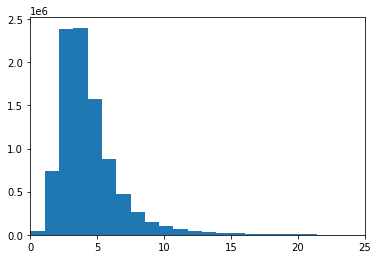

In [70]:
plt.hist(model_data['no_of_days_after_payment'], bins = 200)
plt.xlim(0, 25)

<AxesSubplot:xlabel='distance', ylabel='no_of_days_after_payment'>

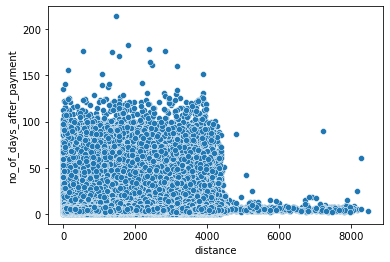

In [73]:
sns.scatterplot(x = model_data['distance'], y = model_data['no_of_days_after_payment'])

<AxesSubplot:xlabel='shipment_method_id', ylabel='distance'>

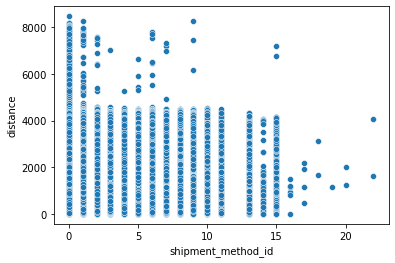

In [75]:
sns.scatterplot(x = model_data['shipment_method_id'], y = model_data['distance'])